# **Exploratory Data Analysis**

## Objectives

The objective of this notebook is to perform exploratory data analysis (EDA) on the cleaned cybersecurity intrusion detection dataset. The goal is to engineer features and test hypotheses to generate insights and conclusions.

## Inputs

* Cleaned file: `cybersecurity_data_cleaned.csv`
* Location: `data/processed/cybersecurity_data_cleaned.csv`


## Hypotheses

- **H1: More failed attempts are more likely to be attacks.**
- **H2: Sessions too long or too short are more likely to be attacks.**
- **H3: The number of login attempts is positively correlated with the chance of attack.**
- **H4: Certain protocols are more likely to be used for attacks.**
- **H5: Sessions from less trusted IPs are more likely to be attacks.**
- **H6: Network packet sizes too big or too small are more likely to be attacks**

## Outputs

* Processed file: `cybersecurity_data_eda.csv`
* Location: `data/processed/cybersecurity_data_eda.csv`

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Code projects\\final-hackathon\\cybersecurity-intrusion-detection\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Code projects\\final-hackathon\\cybersecurity-intrusion-detection'

---

# Initial Setup and Extracting Data

Import necessary libraries:
- numpy for numerical operations
- pandas for data manipulation
- seaborn and Matplotlib for data visualization
- scipy stats for statistical analysis

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, chi2_contingency, ttest_ind, mannwhitneyu, spearmanr

The DataFrame is loaded from the cleaned CSV file located at `data/processed/cybersecurity_data_cleaned.csv`.

In [6]:
df = pd.read_csv('data/processed/cybersecurity_intrusion_data_cleaned.csv')
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


---

# Feature Engineering
Existing features are analyzed and transformed to create new features that may be more informative and useful for analysis.

## Log Transformations

Skewed numerical distributions may be misleading and may cause issues with the machinelearning steps later on. In cases where numerical features are heavily right-skewed, applying a log transformation can help normalize the distribution. The distributions of the following features are examined for potential log transformations:
- `session_duration`
- `ip_reputation_score`


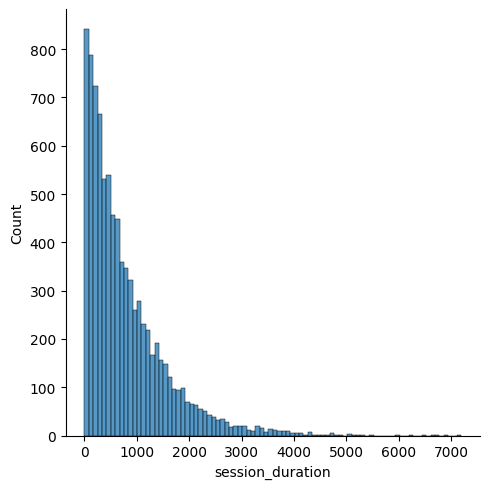

In [7]:
sns.displot(df['session_duration'])
plt.show()

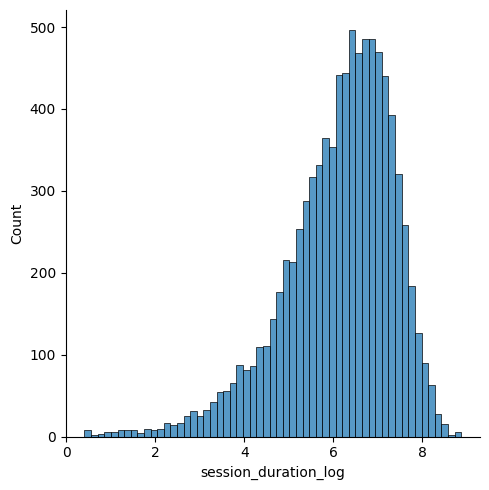

In [8]:
df['session_duration_log'] = np.log1p(df['session_duration'])
sns.displot(df['session_duration_log'])
plt.show()

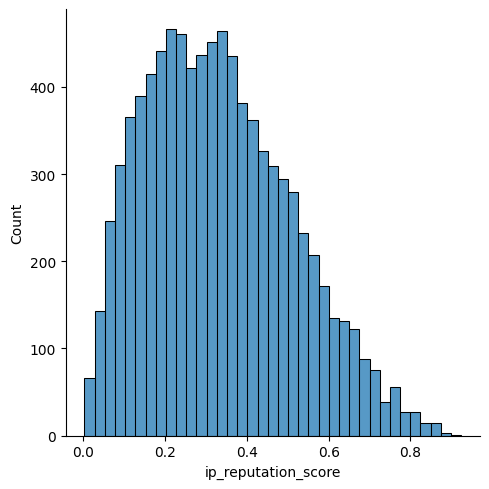

In [9]:
sns.displot(df['ip_reputation_score'])# Base values are more 
plt.show()

In [10]:
df['ip_reputation_score_log'] = np.log1p(df['ip_reputation_score'])

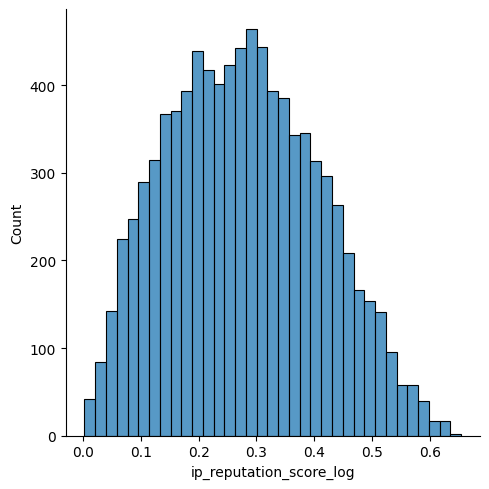

In [11]:
sns.displot(df['ip_reputation_score_log'])
plt.show()

Both features are found to benefit from log transformations, which are applied accordingly. New columns `session_duration_logn` and `ip_reputation_score_log` are created to store the transformed values.

## Flagging Unusual Distrbutions
For the `network_packet_size` feature, there is a noticeable spike at the minimum `network_packet_size` value 0f 64, which may indicate abnormal activity. A new binary feature `network_packet_size_is64` is created to flag sessions with packet sizes equal to 64.

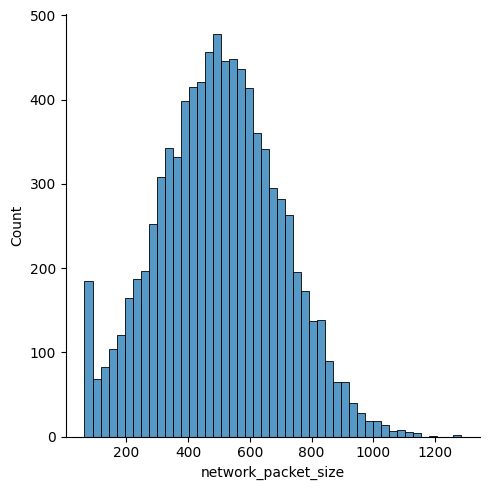

In [12]:
sns.displot(df['network_packet_size'])
plt.show()

In [13]:
(df['network_packet_size'] == 64).sum()

132

Create the new feature by checking if `network_packet_size` equals 64

In [14]:
df['network_packet_size_is64'] = df['network_packet_size'] == 64
df

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,session_duration_log,ip_reputation_score_log,network_packet_size_is64
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1,6.202502,0.474256,False
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0,7.351798,0.263570,False
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1,4.331316,0.553405,False
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1,6.400671,0.116242,False
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0,6.279536,0.053421,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1,5.425170,0.417220,False
8803,SID_09534,380,TCP,3,182.848475,No encryption,0.408485,0,Chrome,0,0,5.214112,0.342515,False
8804,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0,3.588237,0.306896,False
8805,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0,4.473519,0.430104,False


Checking the instances where the new feature is true is equivalent to checking where `network_packet_size` equals 64.

In [15]:
(df['network_packet_size_is64'] == True).sum()

132

## Failing to Login Attempts Ratio
A new feature `fail_ratio` is created to capture the ratio of failed login attempts to total login attempts. This feature may provide insights into the likelihood of an attack based on login behavior.

In [16]:
df['fail_ratio'] = df['failed_logins'] / df['login_attempts']
df

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,session_duration_log,ip_reputation_score_log,network_packet_size_is64,fail_ratio
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1,6.202502,0.474256,False,0.250000
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0,7.351798,0.263570,False,0.000000
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1,4.331316,0.553405,False,0.666667
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1,6.400671,0.116242,False,0.000000
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0,6.279536,0.053421,False,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1,5.425170,0.417220,False,1.000000
8803,SID_09534,380,TCP,3,182.848475,No encryption,0.408485,0,Chrome,0,0,5.214112,0.342515,False,0.000000
8804,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0,3.588237,0.306896,False,0.200000
8805,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0,4.473519,0.430104,False,0.250000


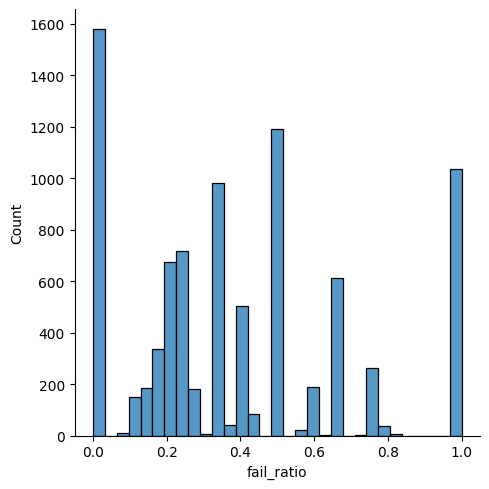

In [17]:
sns.displot(df['fail_ratio'])
plt.show()

The distribution of the new feature is visualized. It is non parametically distributed.

## Loading Processed Data
The processed DataFrame with the new features is saved to a new CSV file located at `data/processed/cybersecurity_data_eda.csv`.

In [18]:
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,session_duration_log,ip_reputation_score_log,network_packet_size_is64,fail_ratio
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1,6.202502,0.474256,False,0.250000
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0,7.351798,0.263570,False,0.000000
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1,4.331316,0.553405,False,0.666667
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1,6.400671,0.116242,False,0.000000
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0,6.279536,0.053421,False,0.200000


In [19]:
df.to_csv('data/processed/cybersecurity_intrusion_data_eda.csv', index=False)

---

# Hypotheses Testing

## Hypothesis 1:
- > H0: More failed logins does not indicate an attack.
- > H1: More failed attempts are more likely to be attacks.

In [20]:
# Split to attack and non-attack groups
df_att = df[df['attack_detected']==1]
df_non_att = df[df['attack_detected']==0]

In [21]:
# Sample and do Shapiro-Wilk test for normality
att_sample = df_att['failed_logins'].sample(500, random_state=123)
non_att_sample = df_non_att['failed_logins'].sample(500, random_state=123)

stat_att, p_att = shapiro(att_sample)
stat_non_att, p_non_att = shapiro(non_att_sample)

print(f"Attack group: stat={stat_att}, p={p_att}")
print(f"Non-attack group: stat={stat_non_att}, p={p_non_att}")

Attack group: stat=0.9046771629357571, p=3.841523727708554e-17
Non-attack group: stat=0.8019297442189296, p=2.933942761904523e-24


Both p-values less than 0.05, reject normality, use Mann-Whitney U test for non-parametric data. Expect higher failed attempts in attack group so use `greater` alternative.

In [22]:
# Mann-Whitney U test
u_stat, p_value = mannwhitneyu(df_att['failed_logins'], df_non_att['failed_logins'], alternative='greater')
print(f"Mann-Whitney U test: U-statistic={u_stat}, p-value={p_value}")

Mann-Whitney U test: U-statistic=12393728.0, p-value=1.618723745844542e-148


Mann-Whitney U test reveals p-value much less than 0.05, enough evidence to reject H0 at the 5% significant level, H1 accepted.

**Conclusion:** ***More failed attempts are more likely to be attacks.***

### Suporting visualizations

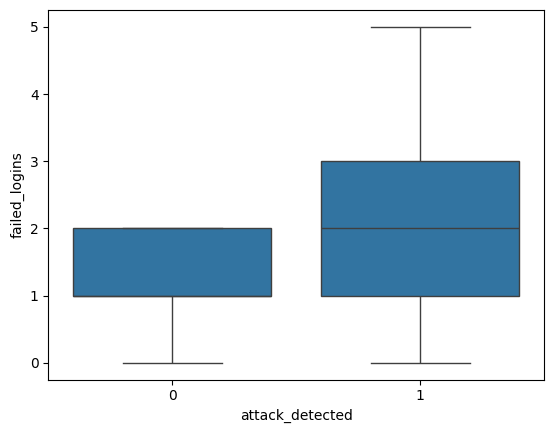

In [23]:
# Boxplot visualization
sns.boxplot(data = df, x='attack_detected', y='failed_logins')
plt.show()

## Hypothesis 2:
- > H0: There is no significant relationship between session duration and the likelihood of an attack.
- > H1: Sessions too long or too short are more likely to be attacks. 

`df_att` and `df_non_att` are used again so normality tests can be skipped. Mann-Whitney U test is used again but with `two-sided` alternative to test for both extremes.

In [24]:
# Mann-Whitney U test
u_stat, p_value = mannwhitneyu(df_att['session_duration'], df_non_att['session_duration'], alternative='two-sided')
print(f"Mann-Whitney U test: U-statistic={u_stat}, p-value={p_value}")

Mann-Whitney U test: U-statistic=9701707.5, p-value=0.06085936458301058


Mann-Whitney U test reveals p-value of 0.06, larger than 0.05, Not enough evidence to reject H0 at the 5% significance level, H0 is accepted.

**Conclusion:** ***There is no significant relationship between session duration and the likelihood of an attack.***

### Supporting visualizations

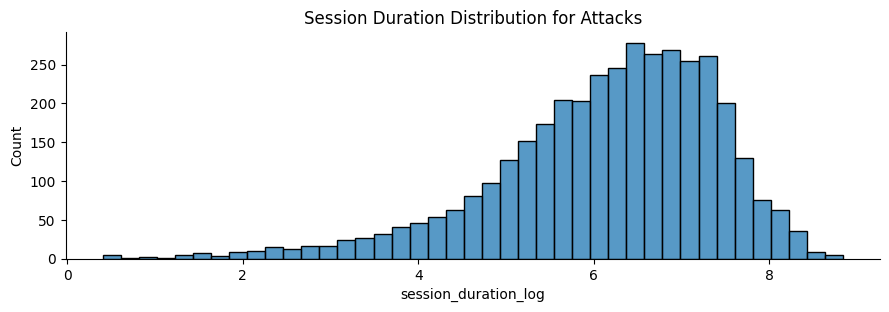

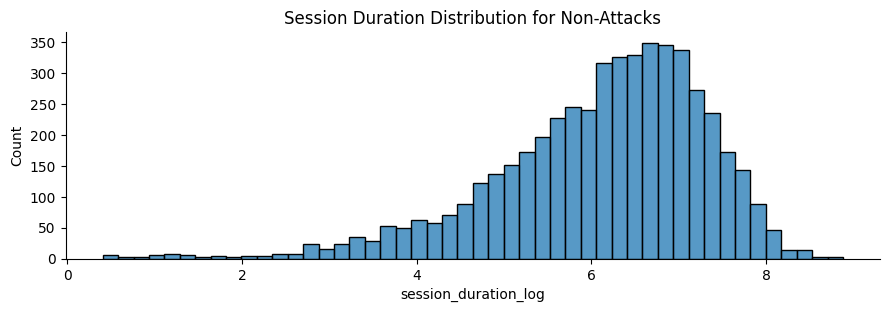

In [25]:
# Distribution plots for session duration
sns.displot(df_att['session_duration_log'], height=3, aspect=3)
plt.title(f'Session Duration Distribution for Attacks')
plt.show()

sns.displot(df_non_att['session_duration_log'], height=3, aspect=3)
plt.title(f'Session Duration Distribution for Non-Attacks')
plt.show()

## Hypothesis 3:
- > H0: There is no correlation between the number of login attempts and the chance of attack.
- > H1: The number of login attempts is positively correlated with the chance of attack.

In [26]:
# Shapiro-Wilk test for login_attempts
stat, p = shapiro(df['login_attempts'].sample(n=5000, random_state=42))
print(f"Shapiro-Wilk test for login_attempts: p = {p}")

Shapiro-Wilk test for login_attempts: p = 1.3509284654120495e-38


Shapiro-Wilk test for `login_attempts` shows non-normality, so use Spearman's rank correlation.

In [27]:
# Spearman's rank correlation
corr, p_value = spearmanr(df['login_attempts'], df['attack_detected'])
print(f"Spearman's rank correlation: corr={corr}, p-value={p_value}")

Spearman's rank correlation: corr=0.32411420767152715, p-value=1.631170541577955e-214


Spearman's rank shows correlation coefficient of 0.32 with p-value much smaller than 0.05. Results shows strong positive correlation. H0 is rejected, H1 is accepted.

**Conclusion:** ***The number of login attempts is positively correlated with the chance of attack.***

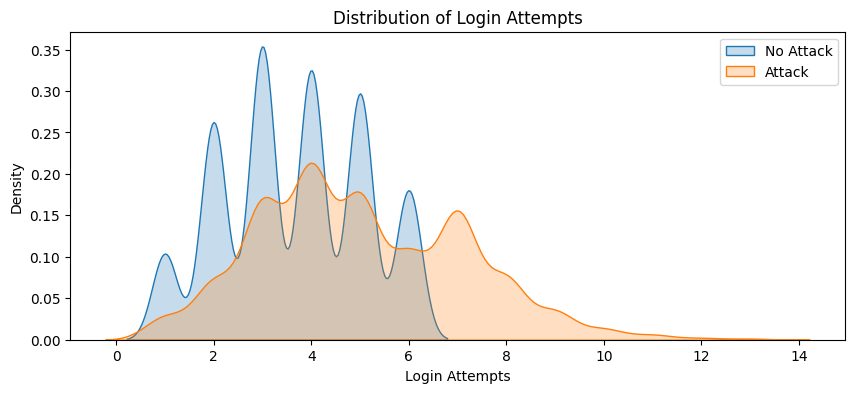

In [28]:
# Distribution plots for login_attempts
plt.figure(figsize=(10, 4))
sns.kdeplot(df[df['attack_detected']==0]['login_attempts'], label='No Attack', fill=True)
sns.kdeplot(df[df['attack_detected']==1]['login_attempts'], label='Attack', fill=True)
plt.title('Distribution of Login Attempts')
plt.xlabel('Login Attempts')
plt.legend()
plt.show()

## Hypothesis 4:
- > H0: No significant difference in numbers of attacks between protocols.
- > H1: Certain protocols are more likely to be used for attacks.

Chi-squared test is used for categorical data.

In [29]:
# Chi-squared test for protocol_type
contingency_table = pd.crosstab(df['protocol_type'], df['attack_detected'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared test: chi2={chi2}, p-value={p}")

Chi-squared test: chi2=4.546516040405871, p-value=0.10297613463186639


Chi-squared test returns p-value of 0.10. As p-value is larger than 0.05, there is not enough evidence to reject H0 at the 5% significance level, H0 is accepted.

**Conclusion:** ***No significant difference in numbers of attacks between protocols.***

### Supporting visualizations

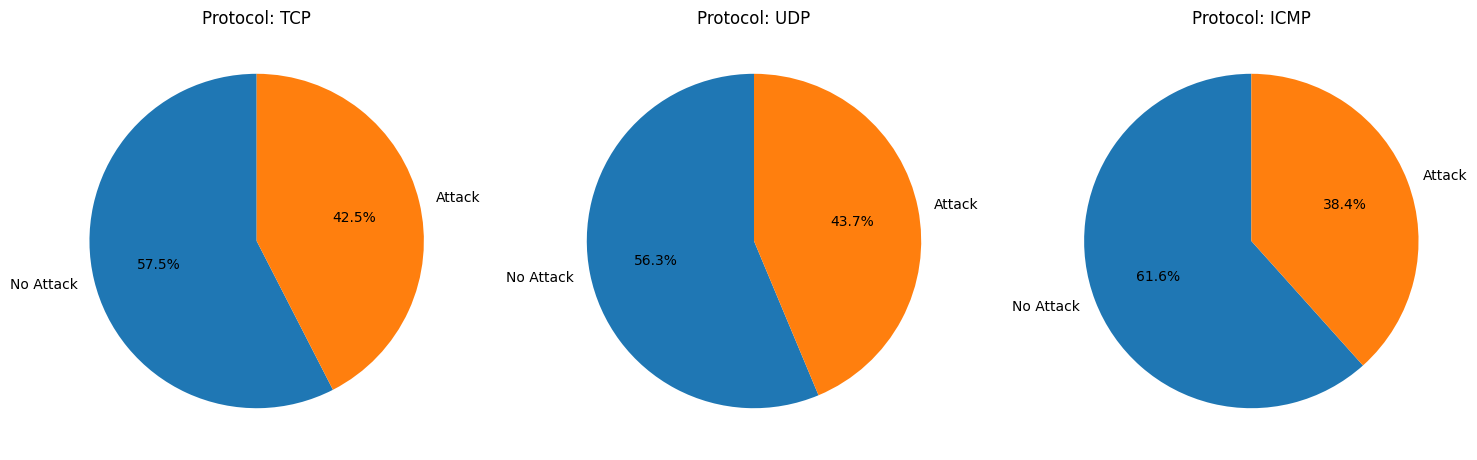

In [30]:
# Pie charts of % attacks of each protocol types
protocol_types = df['protocol_type'].unique() # Get unique protocol types

# Plot pie charts in subplots
fig, ax = plt.subplots(1, len(protocol_types), figsize=(15, 5))
for i, protocol in zip(ax, protocol_types):
    data = df[df['protocol_type'] == protocol]['attack_detected'].value_counts()
    i.pie(
        data, 
        labels=['No Attack', 'Attack'], 
        autopct='%1.1f%%',
        startangle=90
        )
    i.set_title(f'Protocol: {protocol}')
plt.tight_layout()
plt.show()

## Hypothesis 5:
- > H0: High IP Reputation score does not increase number of attacks.
- > H1: Sessions from less trusted IPs are more likely to be attacks.

`df_att` and `df_non_attack` are used, which are known to be non parametric. `ip_reputation` is numerical, so Mann-Whitney U test is used again with `greater` alternative, expecting higher reputation scores in attack group (`ip_reputation` is rated with higher values being less trustworthy).

In [31]:
# Mann-Whitney U test for ip_reputation
u_stat, p_value = mannwhitneyu(df_att['ip_reputation_score'], df_non_att['ip_reputation_score'], alternative='greater')
print(f"Mann-Whitney U test: U-statistic={u_stat}, p-value={p_value}")

Mann-Whitney U test: U-statistic=11449349.0, p-value=7.944258394040855e-63


Mann-Whitney U test returns p-value much smaller than 0.05, there is enough evidence to reject H0 at the 5% significance level. H0 is rejected and H1 is accepted.

**Conclusion:** ***Sessions from less trusted IPs are more likely to be attacks.***

### Supporting visualizations

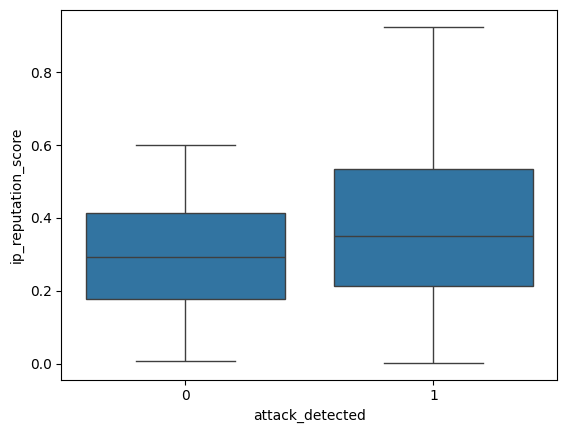

In [32]:
# Boxplot visualization
sns.boxplot(data = df, x='attack_detected', y='ip_reputation_score')
plt.show()

# Hypothesis 6:
- > H0: There is no significant relationship between network packet size and the likelihood of an attack.
- > H1: Network packet sizes too big or too small are more likely to be attacks.

`df_att` and `df_non_att` are used again so normality tests can be skipped. As `network_packet_size` is a numerical value, Mann-Whitney U test is used again but with `two-sided` alternative to test for both extremes.

In [33]:
# Mann-Whitney U test for network_packet_size
u_stat, p_value = mannwhitneyu(df_att['network_packet_size'], df_non_att['network_packet_size'], alternative='two-sided')
print(f"Mann-Whitney U test: U-statistic={u_stat}, p-value={p_value}")

Mann-Whitney U test: U-statistic=9461872.0, p-value=0.874096598488628


### Supporting visualizations

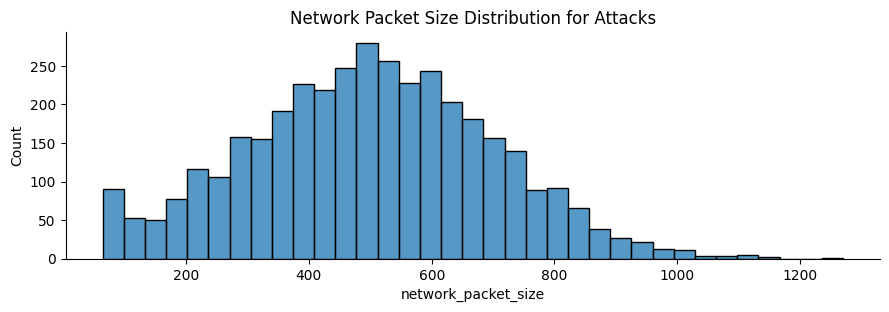

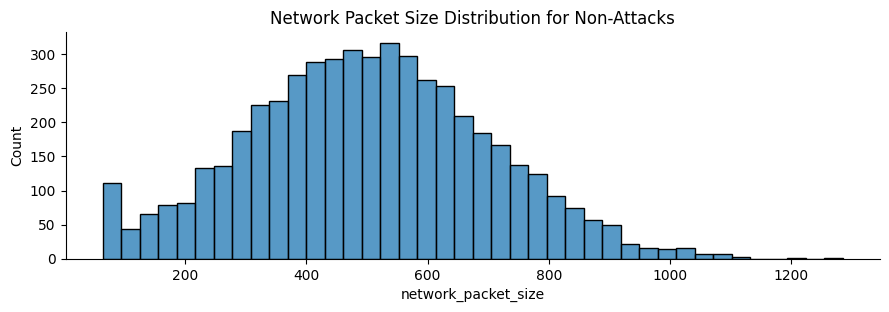

In [34]:
## Distribution plots for network_packet_size
sns.displot(df_att['network_packet_size'], height=3, aspect=3) # Plot for attack group
plt.title(f'Network Packet Size Distribution for Attacks')
plt.show()

sns.displot(df_non_att['network_packet_size'], height=3, aspect=3) # Plot for non-attack group
plt.title(f'Network Packet Size Distribution for Non-Attacks')
plt.show()

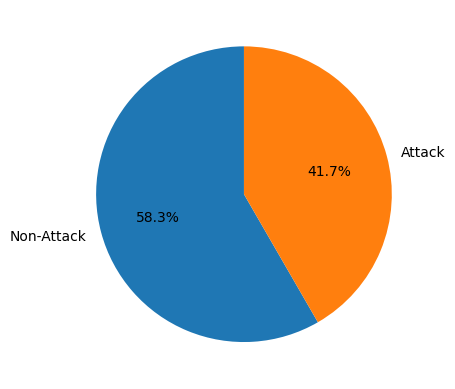

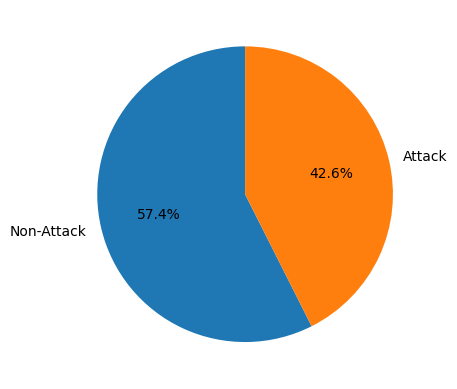

In [38]:
# Pie charts of % attacks of network_packet_size_is64
data = df[df['network_packet_size_is64']==True]['attack_detected'].value_counts()
plt.pie(
    data, 
    labels=['Non-Attack', 'Attack'], 
    autopct='%1.1f%%',
    startangle=90
    )
plt.show()

data = df[df['network_packet_size_is64']==False]['attack_detected'].value_counts()
plt.pie(
    data, 
    labels=['Non-Attack', 'Attack'], 
    autopct='%1.1f%%',
    startangle=90
    )
plt.show()

---

# Conclusions


**What was done:**
- Engineered new features: `session_duration_logn`, `ip_reputation_score_log`, `network_packet_size_is64`, `fail_ratio`.
- Saved processed DataFrame to CSV.
- Conducted statistical hypothesis testing.  
- Visualized distributions and relationships.

**Key insights:**
- More failed login attempts are associated with higher likelihood of attacks.
- The number of login attempts is positively correlated with the chance of attack.
- Sessions from less trusted IPs are more likely to be attacks.
- No significant relationship between session duration and attack likelihood.
- No significant difference in attack numbers between protocols.
